# UTMIST Workshop #3: Histopathologic Cancer Detection
Hello UTMIST community!

In this workshop, we will be building a model that will compete at a Histopathologic Cancer Detection Competition on Kaggle, which can be found here https://www.kaggle.com/competitions/histopathologic-cancer-detection.
As stated on their website, our algorithm will identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. In this dataset, we are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

Authors: Berke Altiparmak (altiparmak.berke@gmail.com), Lindy Zhai (lindy.zhai@mail.utoronto.ca)

References:
https://www.kaggle.com/code/bonhart/pytorch-cnn-from-scratch for the model.

https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93 for data visualization.

**Important Note:** The project was built on Kaggle, so in order to actually run the project, go to https://www.kaggle.com/code/berkealtiparmak/utmist-workshop-3

# Step 1: Importing libraries

We will import the libraries that we need to build our CNN model. Keep in mind that those libraries are not specific for this project; we are keep using the same libraries, so it is useful for you to get familiar with them.

In [ ]:
import os
import time
from glob import glob 
import numpy as np  # for math operations, one of the most commonly used libraries
import pandas as pd  # for handling data and data frames, another essential library
import cv2  # OpenCV library, which we will use to "read" images and transform them
import matplotlib.pyplot as plt  # to visualize data
from tqdm import tqdm_notebook,trange  # to see the progress
import gc #garbage collection to save RAM

# the output of plotting commands is displayed inline within Jupyter notebook:
%matplotlib inline  

from sklearn.model_selection import train_test_split  # to split train and validation data

# PyTorch libraries to build a Machine Learning Model:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Step 2: Understanding and Visualizing The Data

In this section, we will first get our training, validation, and test data, and then we will visualize some of the data we have. Moving on, we'll take a deeper look into our data by analyzing the positive and negative data distribution, and then we will compare the properties of positive samples and negative samples to see if it is actually possible to tell a positive and negative sample apart just from an image.

In [ ]:
#set paths to training and test data
path = "../input/" #adapt this path, when running locally
train_path = path + 'train/'
test_path = path + 'test/'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
submission = pd.read_csv('../input/sample_submission.csv')

#Splitting data into train and val
train, val = train_test_split(labels, stratify=labels.label, test_size=0.1)  # stratify keeps the proportion
print(len(train))
print(len(val))

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) # keep only the file names in 'id'
df = df.merge(labels, on = "id") # merge labels and filepaths

df.head(10) # print the first ten entries

198022
22003


,path,id,label
0,../input/train/d43c081bafa286f9c1f7e921883f26c...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/train/092d0eedebce504847715ee046b6ad7...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/train/b0d2582c6218a8764323fc940b41312...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,../input/train/187c99df762f13f99818e5593d4bab4...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,../input/train/7c5270c83837de5a5cbb2dca511559d...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1
5,../input/train/5a32933e093185f5fc91d30fc83ad57...,5a32933e093185f5fc91d30fc83ad571c6818d25,1
6,../input/train/42e77d193e73811e0bb65a0cbd9b01c...,42e77d193e73811e0bb65a0cbd9b01c5c27900fa,0
7,../input/train/27bb898f54a0b9345f6c4a9083299e4...,27bb898f54a0b9345f6c4a9083299e4465860861,0
8,../input/train/89cd55e4300440612347c38f306da68...,89cd55e4300440612347c38f306da688a166fd40,0
9,../input/train/cd600f77aa2af7c93dc6cd836e44eda...,cd600f77aa2af7c93dc6cd836e44edada3d8c403,0


In [ ]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [ ]:
N=1000
X,y = load_data(N=N,df=df) # load 1000 images

## Let's see what our data looks like!
We will  look at 16 images with labels. A positive label (0) indicates that the image contains a tumor tissue. A negative label (1) implies the lack of tumor tissues in the image.

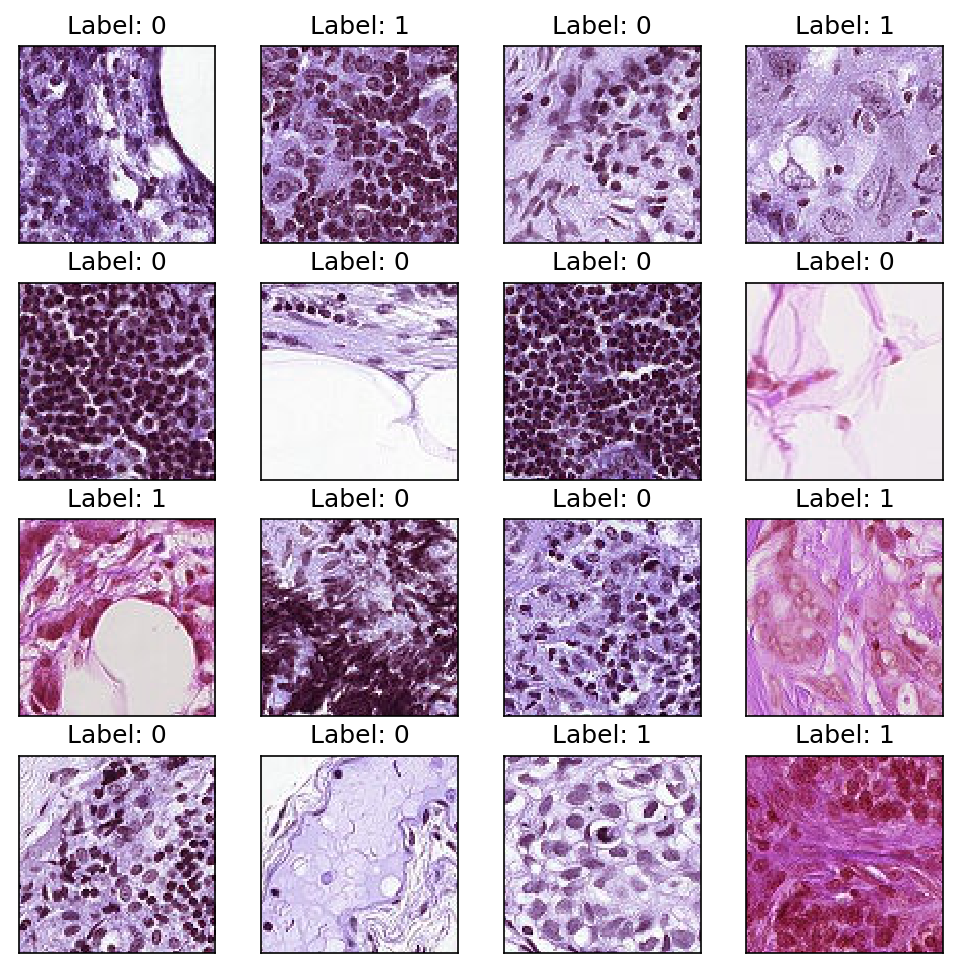

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=150)
np.random.seed(100) #we can use the seed to get a different set of random images
image_count = 16  # number of images we want to have
for plot_idx,image_idx in enumerate(np.random.randint(0,N,image_count)):
    ax = fig.add_subplot(4, image_count//4, plot_idx+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[image_idx]) #plot image
    ax.set_title('Label: ' + str(y[image_idx])) #show the label corresponding to the image

## Let's analyze the positive and negative sample distribution in our data to see if it has any bias.

Text(0, 0.5, '# of samples')

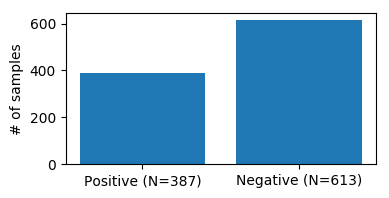

In [ ]:
fig = plt.figure(figsize=(4, 2),dpi=100)
number_of_negatives = (y==0).sum()
number_of_positives = (y==1).sum()
negative_samples = X[y == 0]
positive_samples = X[y == 1]
plt.bar([1,0], [number_of_negatives, number_of_positives]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format(number_of_negatives),"Positive (N={})".format(number_of_positives)]);
plt.ylabel("# of samples")

### Now, we wonder if it's possible to tell a positive and a negative sample apart from each other just from an image. To check that, we will look at whether negative samples generally have different color or brightness compare to the positive samples.
* First, compare each color channel (red, green, blue) of positive and negatives.
* Then, make a cumulative comparison.
* Finally, compare overall brightness.
* Scroll back up and compare your conclusions with the 16 image sample you have. Is it accurate? Specifically, check if your observations for red and brightness is generally true so far.

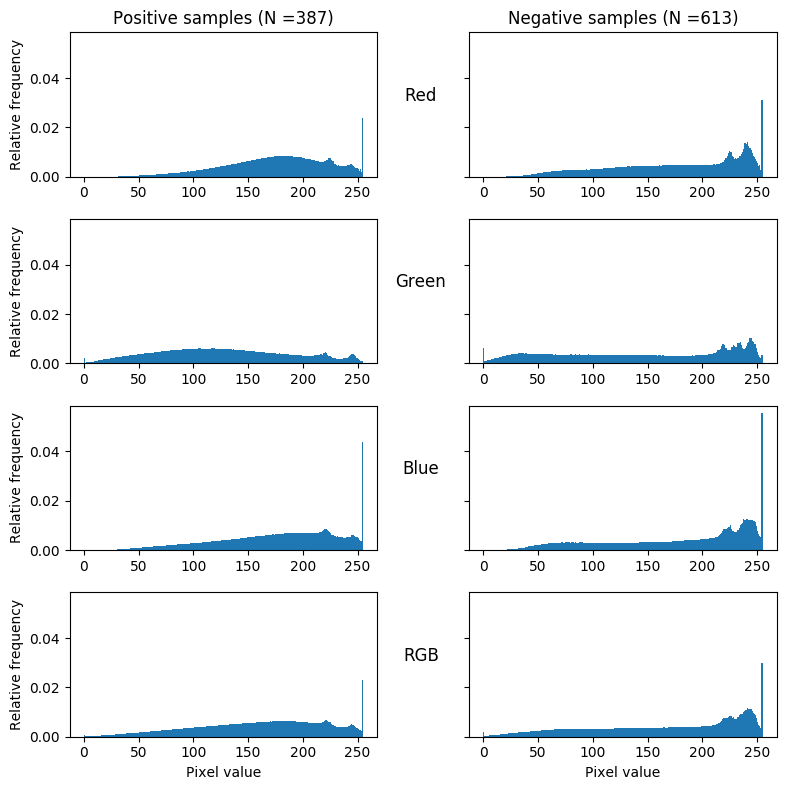

In [ ]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=100)
rgb_list = ["Red", "Green", "Blue", "RGB"]

for row_idx in range(0, 4):
    for col_idx in range(0, 2):
        # do these two below later berke
        axs[row_idx,0].set_ylabel("Relative frequency")
        axs[row_idx,1].set_ylabel(rgb_list[row_idx],rotation='horizontal',labelpad=35,fontsize=12)
        if row_idx < 3:
            if col_idx == 0:
                axs[row_idx, col_idx].hist(positive_samples[:,:,:,row_idx].flatten(),bins=nr_of_bins,density=True)
            elif col_idx == 1:
                axs[row_idx, col_idx].hist(negative_samples[:,:,:,row_idx].flatten(),bins=nr_of_bins,density=True)
        else:
            if col_idx == 0:
                axs[row_idx, col_idx].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
            elif col_idx == 1:
                axs[row_idx, col_idx].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

# Additional labeling
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")

fig.tight_layout()

# Step 3: Preprocessing the Data
Now that we have our data, we want to turn it into something that our CNN model can take as an input. In order to improve the accuracy of our model in the real world, we will introduce something called transformations. Transformations allow us to play with our data so that they are imperfect and unpredictable, which intuitively sounds weird, but it actually helps our model to be have a greater test accuracy because it prevents overfitting. Transformations also allow us to have more variety, which again imrpoves the real world application of it.

In [ ]:
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
dataset_train = MyDataset(df_data=train, data_dir=train_path, transform=trans_train)
dataset_valid = MyDataset(df_data=val, data_dir=train_path, transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


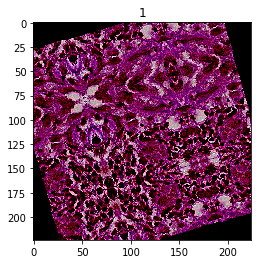

In [ ]:
import random
random.seed(20)  # Choosing a seed to randomly generate a number
rand_idx = int(random.random() * len(dataset_train))  # Randomly choosing an index
image, label = dataset_train[rand_idx]  # Random image
plt.imshow(image.permute(1, 2, 0))  # Make it (h, w, c)
plt.title(label)
plt.show()

# Step 4: Building the CNN Model!
We've made it! We analyzed and processed our data, and now we are ready to build our model that will train on it to later predict images that it has never seen before.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(1024 * 1 * 1, 2)
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.pool(F.leaky_relu(self.bn6(self.conv6(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Set up your parameters and create your model
Make sure you understand what each parameter and object is used for.

In [ ]:
# Hyper parameters
num_epochs = 8
num_classes = 2
batch_size = 32
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = SimpleCNN().to(device)

## Backpropagation: Choosing your Cost Function and Optimizer
We are using CrossEntropyLoss as our cost function, and Adamax as our optimizer, a Stochastic Optimization.

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

## Create your Training Loop
This is where your model actually trains. The training loop should keep the model with the lowest loss, which we will use to predict labels for the images in our test set

In [ ]:
# Train the model
total_num = 1000

# total_step = len(loader_train)
total_step = int(total_num/batch_size)
if total_num%batch_size != 0:
    total_step += 1 
print('total is ', total_step)
for epoch in range(num_epochs):
#     print(epoch)
    step, data_count = 0,0
    start = time.time()
    for images, labels in iter(loader_train):
        data_count += len(images)
#     for i, (images, labels) in enumerate(loader_train):
#         print(images.shape)
#         start = time.time()
        if torch.cuda.is_available():
#             print('cuda here')
            images = images.cuda()
            labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (step+1) % 10 == 0:
            end = time.time()
            print("============================== step runtime from start of current epoch {} ====================================".format(end - start))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, step+1, total_step, loss.item()))
            
        step += 1
        if (data_count > total_num):
            end = time.time()
            print("============================== EPOCH RUN COMPLETED ====================================",end - start)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, step+1, total_step, loss.item()))
            break

total is  32
============================== step runtime from start of current epoch 4.467304706573486 ====================================
Epoch [1/8], Step [10/32], Loss: 0.7064
============================== step runtime from start of current epoch 8.18090271949768 ====================================
Epoch [1/8], Step [20/32], Loss: 0.6332
============================== step runtime from start of current epoch 11.754588603973389 ====================================
Epoch [1/8], Step [30/32], Loss: 0.5935
============================== EPOCH RUN COMPLETED ==================================== 12.59457540512085
Epoch [1/8], Step [33/32], Loss: 0.5480
============================== step runtime from start of current epoch 3.456284999847412 ====================================
Epoch [2/8], Step [10/32], Loss: 0.4544
============================== step runtime from start of current epoch 7.150542259216309 ====================================
Epoch [2/8], Step [20/32], Loss: 0.6461
======

## Validate the Accuracy of your Model
We are using the validation data set to compare the model's predictions with the actual results. Notice that we are no longer training our model here.

In [ ]:
# Test the model

testing_num = 2000

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if(total>testing_num):
            break
          
    print('Test Accuracy of the model on the 22003 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 22003 test images: 81.99404761904762 %


## Submit your Model to the Competition!
We will not do this in our workshop because it takes time to evaluate our model, but feel free to do it on your own! The code is provided below.

In [ ]:
dataset_valid = MyDataset(df_data=submission, data_dir=test_path, transform=trans_valid)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)

In [ ]:

model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
sub.shape, len(preds)
sub['label'] = preds
sub.to_csv('s.csv', index=False)